# 基于iTransformer的时间序列预测

In [12]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import os
from tqdm import tqdm # 打印进度条
import math
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

## 多变量多步预测

### 数据准备

In [28]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [29]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
...,...,...
2014-12-31 19:00:00,"4,012.00",18.00
2014-12-31 20:00:00,"3,856.00",16.67
2014-12-31 21:00:00,"3,671.00",17.00
2014-12-31 22:00:00,"3,499.00",15.33


In [30]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [31]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [32]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [33]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 1]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 1]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 1]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型训练

In [34]:
# 倒置编码
class DataEmbedding_inverted(nn.Module):
    def __init__(self, seq_len, d_model, dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(seq_len, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1))
        # x: [Batch Variate d_model]
        return self.dropout(x)

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

# iTransformer模型
class iTransformer(nn.Module):
    def __init__(self, seq_len, pred_len, output_attention, d_model, dropout, n_heads, d_ff, e_layers, activation):
        super(iTransformer, self).__init__()
        # 参数配置
        self.seq_len = seq_len # seq_len输入时间步
        self.pred_len = pred_len # pred_len输出时间步
        self.output_attention = output_attention # 是否在ecoder中输出注意力

        # Embedding
        self.enc_embedding = DataEmbedding_inverted(seq_len, d_model, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, attention_dropout=dropout,
                                      output_attention=output_attention), d_model, n_heads),
                    d_model, # 隐藏层数
                    d_ff, # ecoder中卷积层输出维度
                    dropout=dropout,
                    activation=activation # 激活函数
                ) for l in range(e_layers) # encoder layers的层数
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )

        # Decoder
        self.projection = nn.Linear(d_model, pred_len, bias=True)

    def forward(self, x_enc, x_mark_enc=None):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev

        _, _, N = x_enc.shape

        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)

        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        dec_out = self.projection(enc_out).permute(0, 2, 1)[:, :, :N]
        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))

        # output
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

In [35]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
#     print(f_dim)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  2%|█▋                                                                                 | 1/50 [00:04<03:23,  4.16s/it]

Epoch [1/50], Training Loss: 0.0039, Validation Loss: 0.0051
Validation loss decreased (inf --> 0.005099).  Saving model ...
Updating learning rate to 0.0009990133642141358


  4%|███▎                                                                               | 2/50 [00:08<03:12,  4.02s/it]

Epoch [2/50], Training Loss: 0.0029, Validation Loss: 0.0049
Validation loss decreased (0.005099 --> 0.004914).  Saving model ...
Updating learning rate to 0.000996057350657239


  6%|████▉                                                                              | 3/50 [00:11<03:04,  3.92s/it]

Epoch [3/50], Training Loss: 0.0027, Validation Loss: 0.0048
Validation loss decreased (0.004914 --> 0.004809).  Saving model ...
Updating learning rate to 0.0009911436253643444


  8%|██████▋                                                                            | 4/50 [00:15<02:58,  3.87s/it]

Epoch [4/50], Training Loss: 0.0025, Validation Loss: 0.0051
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0009842915805643156


 10%|████████▎                                                                          | 5/50 [00:19<02:54,  3.88s/it]

Epoch [5/50], Training Loss: 0.0025, Validation Loss: 0.0045
Validation loss decreased (0.004809 --> 0.004454).  Saving model ...
Updating learning rate to 0.0009755282581475768


 12%|█████████▉                                                                         | 6/50 [00:23<02:53,  3.93s/it]

Epoch [6/50], Training Loss: 0.0024, Validation Loss: 0.0049
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0009648882429441257


 14%|███████████▌                                                                       | 7/50 [00:27<02:52,  4.00s/it]

Epoch [7/50], Training Loss: 0.0023, Validation Loss: 0.0045
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.0009524135262330098


 16%|█████████████▎                                                                     | 8/50 [00:31<02:46,  3.95s/it]

Epoch [8/50], Training Loss: 0.0023, Validation Loss: 0.0042
Validation loss decreased (0.004454 --> 0.004223).  Saving model ...
Updating learning rate to 0.0009381533400219318


 18%|██████████████▉                                                                    | 9/50 [00:35<02:45,  4.04s/it]

Epoch [9/50], Training Loss: 0.0023, Validation Loss: 0.0045
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0009221639627510075


 20%|████████████████▍                                                                 | 10/50 [00:40<02:46,  4.16s/it]

Epoch [10/50], Training Loss: 0.0022, Validation Loss: 0.0047
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.0009045084971874737


 22%|██████████████████                                                                | 11/50 [00:44<02:39,  4.10s/it]

Epoch [11/50], Training Loss: 0.0022, Validation Loss: 0.0049
EarlyStopping counter: 3 out of 7
Updating learning rate to 0.0008852566213878947


 24%|███████████████████▋                                                              | 12/50 [00:48<02:35,  4.08s/it]

Epoch [12/50], Training Loss: 0.0022, Validation Loss: 0.0042
Validation loss decreased (0.004223 --> 0.004159).  Saving model ...
Updating learning rate to 0.0008644843137107057


 26%|█████████████████████▎                                                            | 13/50 [00:52<02:33,  4.16s/it]

Epoch [13/50], Training Loss: 0.0022, Validation Loss: 0.0044
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0008422735529643444


 28%|██████████████████████▉                                                           | 14/50 [00:57<02:34,  4.30s/it]

Epoch [14/50], Training Loss: 0.0021, Validation Loss: 0.0043
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.0008187119948743449


 30%|████████████████████████▌                                                         | 15/50 [01:01<02:35,  4.43s/it]

Epoch [15/50], Training Loss: 0.0021, Validation Loss: 0.0040
Validation loss decreased (0.004159 --> 0.004035).  Saving model ...
Updating learning rate to 0.0007938926261462366


 32%|██████████████████████████▏                                                       | 16/50 [01:05<02:26,  4.31s/it]

Epoch [16/50], Training Loss: 0.0020, Validation Loss: 0.0038
Validation loss decreased (0.004035 --> 0.003821).  Saving model ...
Updating learning rate to 0.0007679133974894983


 34%|███████████████████████████▉                                                      | 17/50 [01:09<02:18,  4.19s/it]

Epoch [17/50], Training Loss: 0.0020, Validation Loss: 0.0047
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0007408768370508576


 36%|█████████████████████████████▌                                                    | 18/50 [01:13<02:10,  4.08s/it]

Epoch [18/50], Training Loss: 0.0020, Validation Loss: 0.0043
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.0007128896457825364


 38%|███████████████████████████████▏                                                  | 19/50 [01:17<02:04,  4.01s/it]

Epoch [19/50], Training Loss: 0.0020, Validation Loss: 0.0037
Validation loss decreased (0.003821 --> 0.003715).  Saving model ...
Updating learning rate to 0.0006840622763423391


 40%|████████████████████████████████▊                                                 | 20/50 [01:21<01:59,  3.97s/it]

Epoch [20/50], Training Loss: 0.0019, Validation Loss: 0.0039
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0006545084971874737


 42%|██████████████████████████████████▍                                               | 21/50 [01:25<01:54,  3.94s/it]

Epoch [21/50], Training Loss: 0.0019, Validation Loss: 0.0049
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.0006243449435824276


 44%|████████████████████████████████████                                              | 22/50 [01:29<01:49,  3.91s/it]

Epoch [22/50], Training Loss: 0.0019, Validation Loss: 0.0040
EarlyStopping counter: 3 out of 7
Updating learning rate to 0.0005936906572928624


 46%|█████████████████████████████████████▋                                            | 23/50 [01:33<01:45,  3.90s/it]

Epoch [23/50], Training Loss: 0.0019, Validation Loss: 0.0040
EarlyStopping counter: 4 out of 7
Updating learning rate to 0.0005626666167821521


 48%|███████████████████████████████████████▎                                          | 24/50 [01:36<01:40,  3.88s/it]

Epoch [24/50], Training Loss: 0.0019, Validation Loss: 0.0037
EarlyStopping counter: 5 out of 7
Updating learning rate to 0.0005313952597646568


 50%|█████████████████████████████████████████                                         | 25/50 [01:40<01:37,  3.90s/it]

Epoch [25/50], Training Loss: 0.0019, Validation Loss: 0.0038
EarlyStopping counter: 6 out of 7
Updating learning rate to 0.0005


 50%|█████████████████████████████████████████                                         | 25/50 [01:44<01:44,  4.19s/it]

Epoch [26/50], Training Loss: 0.0018, Validation Loss: 0.0040
EarlyStopping counter: 7 out of 7
Early stopping!


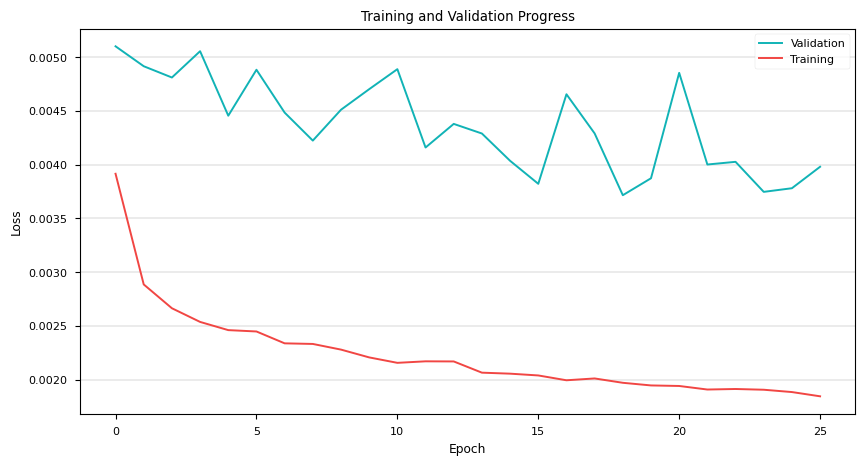

In [36]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load'],
        "target": ['load'],
        "features": 'S'
    },
    "train_args": {
        "model_name": iTransformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 50,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 2 * 3,
        'pred_len': 3,
        'output_attention': False,
        'd_model': 128,
        'n_heads': 8,
        'd_ff': 512,
        'dropout': 0.1,
        'e_layers': 1,
        'activation': "relu"
    },
}
model = train(**params3)

### 模型预测

In [37]:
def predict(task_args, predict_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    model = predict_args['model'] 
    X_train = predict_args['X_train'] 
    X_valid = predict_args['X_valid'] 
    X_test = predict_args['X_test'] 
    y_train = predict_args['y_train'] 
    y_valid = predict_args['y_valid'] 
    y_test = predict_args['y_test'] 
    y_true = predict_args['y_true'] 
    lookback = predict_args['lookback']
    delay = predict_args['delay']
    scaler = predict_args['scaler']
    lookback = lookback - 1 # 包含当前时间点
    
    # 预测任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            if len(target) > 1:
                raise ValueError("target must be one of columns!")
            else:
                target = target[0]
                f_dim = col_dict[target]
        return f_dim
    f_dim = forecasting_task(columns, target, features)
        
    # 数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    # 时间序列形状
    timeseries_y = y_true.values[:, f_dim].reshape(-1, 1)
    timeseries_x = y_true.index
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
        if features == 'S':
            y_pred = y_pred[:, f_dim:]
        else:
            y_pred = y_pred[:, f_dim: f_dim+1]
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
        if features == 'S':
            y_pred = y_pred[:, f_dim:]
        else:
            y_pred = y_pred[:, f_dim: f_dim+1]
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
        if features == 'S':
            y_pred = y_pred[:, f_dim:]
        else:
            y_pred = y_pred[:, f_dim: f_dim+1]
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [38]:
# 构造参数字典
params4 = {
    "task_args":{
        "columns": ['load'],
        "target": ['load'],
        "features": 'S'
    },
    "predict_args": {
        "model": model,
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test,
        "y_true": ts_data,
        "lookback": 6,
        "delay": 3,
        "scaler": scaler,
    }
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

### 结果分析

In [39]:
# 局部静态图
def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
    timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
    timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

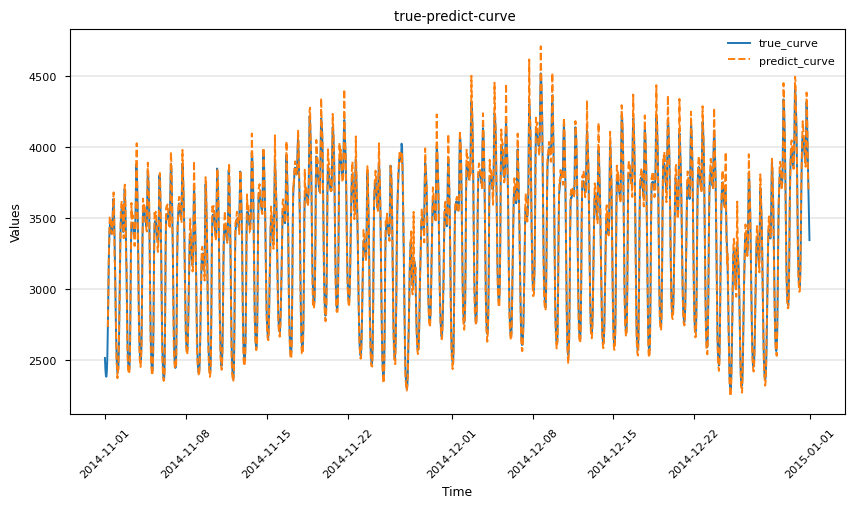

In [40]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

In [41]:
# 全局静态图
def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

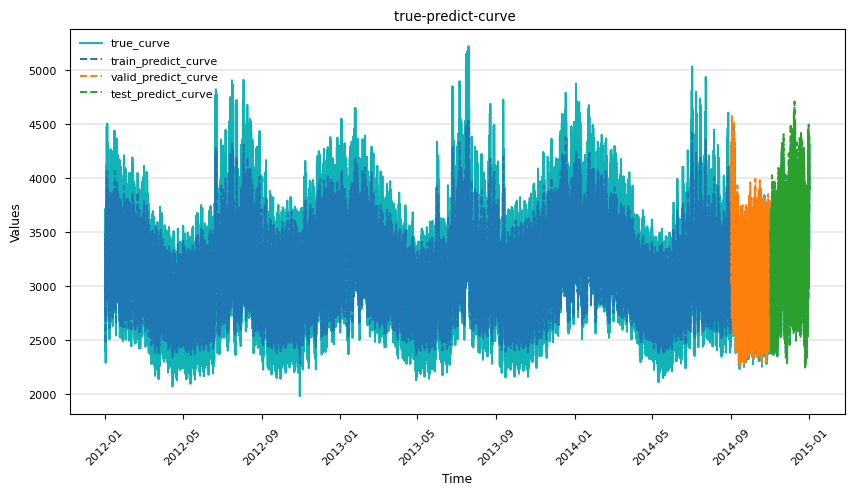

In [42]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

# 基于TimesNet的时间序列预测